In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linmix
from astropy.table import Table
from astropy.table import Column
import astropy.io.ascii as ascii
from lifelines import KaplanMeierFitter
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline
#%matplotlib qt5

In [2]:
#   read data   #


Tab=Table.read("Table.fit")      #Taurus fluxes and disk mass Tab
Tab_Mass=Table.read("Table_Mass.fit")   #Taurus stellar masses (2-3 models) Tab
Lup_Tab=Table.read('Lupus_Tab.fit')      #Lupus Tab without the 20 obscured sources.
Lup_Tab_tot=Table.read('Lupus_Tab_TOT.fit') #Lupus tab with the 20 obscured sources.
#LupTab_Hsi=Table.read('LupTab_Hsi.fit')     #Lupus Tab from Hsi-Wei
ChaI_Tab_orig=Table.read('ChaI_Tab.fit')
UppSco_Tab=Table.read('UppSco_Tab.fit')

Mgas_Lup_orig=Table.read('Mgas_Lup.dat',format='ascii')
Mgas_ChaI=ascii.read('Mgas_ChaI.tex',format='latex')

ChaI_Tab=ChaI_Tab_orig.copy()
ChaI_Tab.remove_rows(36)      #removing source without measurement of Mgas
print len(Lup_Tab_tot)

###########
#  remove from gas tab the 20 obscured sources in dust tab. IN LUPUS
Lup_Ms=Table.read('Lup_Ms.fit')
Lup_Ms.remove_rows([13,14,16,35,53]) #removing non observed sources + Sz82 that isn't in Table of Miotello+17

nnan=np.isnan(Lup_Ms['Mass'])        #20 obscured sources
notnan=np.logical_not(nnan)
 
index=np.where(nnan)
Mgas_Lup=Mgas_Lup_orig.copy()
Mgas_Lup.remove_rows(index)
###############

limMs=np.where(10**Tab_Mass['LogM*3']>=0.1)   #removing the brown dwarfs to Taurus   on S00 presequence model.

d_Tau=Tab['l'][limMs]!='<'            #observed sources
d_Lup=Lup_Tab['l_Md']!='<'      #observed sources
d_Lup_tot=Lup_Tab_tot['l_Md']!='<'      #observed sources
d_ChaI=ChaI_Tab['l_Md']!='<'      #observed sources
d_UppSco=UppSco_Tab['l_Md']!='<'      #observed sources
notd_Lup=np.logical_not(d_Lup)

delta=(d_Tau,d_Lup,d_ChaI,d_UppSco)
notdelta=(np.logical_not(d_Tau),np.logical_not(d_Lup),np.logical_not(d_ChaI),np.logical_not(d_UppSco)) #upperlimits

### detection for gas
dGas_Lup=Mgas_Lup['l_Mgas']!='<'      #observed sources for Mgas
dGas_ChaI=Mgas_ChaI['l_Mgas']!='<'      #observed sources for Mgas

dGas=(dGas_Lup,dGas_ChaI)
notdGas=(np.logical_not(dGas_Lup),np.logical_not(dGas_ChaI))

## Stellar masses
logMs_Tau=Tab_Mass['LogM*3'][limMs]    # S00 presequence model.
logMs_Lup=np.log10(Lup_Tab['M*']) 
logMs_ChaI=ChaI_Tab['logM*']
logMs_UppSco=UppSco_Tab['logM*']

logMs=(logMs_Tau,logMs_Lup,logMs_ChaI,logMs_UppSco)


## Dust masses:
Md_Lup=Lup_Tab['Md']
e_Md_Lup=Lup_Tab['err_Md']
ecal_MdLup=np.sqrt((Lup_Tab['err_Md'])**2+(0.1*Lup_Tab['Md'])**2)  
#quadratic sum of the calibration error on Md (10%)

logMd20_Tau=Tab['LogMd_20'][limMs]
logMd_Lup=np.log10(Lup_Tab['Md'])
logMd_ChaI=np.log10(ChaI_Tab['Md'])
logMd180_ChaI=np.log10(ChaI_Tab['Md_180'])    #dust masses computed at distance 180 pc
logMd_UppSco=np.log10(UppSco_Tab['Md_20'])

#logMd=(logMd20_Tau,logMd_Lup,logMd_ChaI,logMd_UppSco)
logMd=(logMd20_Tau,logMd_Lup,logMd180_ChaI,logMd_UppSco)

## Gas masses:
logMg_Lup=Mgas_Lup['logMgas']   
logMg_ChaI=Mgas_ChaI['logMgas']   # in solar masses
logMg=(logMg_Lup,logMg_ChaI)

## Outer dust radii:
logR_out=np.full(len(Lup_Tab),0.)
Dp_Rout=np.full(len(Lup_Tab),0.)
Dn_Rout=np.full(len(Lup_Tab),0.)
i_Rad=[]
for i in range(len(Lup_Tab)):
    if Lup_Tab['R_out'][i] != 0.:   # take the non-zero values
        i_Rad.append(i)
        
logR_out[i_Rad]=np.log10(Lup_Tab['R_out'][i_Rad])
## errors on Rout
Dp_Rout[i_Rad]=np.log10(Lup_Tab['R_out'][i_Rad]+Lup_Tab['eR_out'][i_Rad])-logR_out[i_Rad]
Dn_Rout[i_Rad]=logR_out[i_Rad]-np.log10(Lup_Tab['R_out'][i_Rad]-Lup_Tab['eR_out'][i_Rad])

## Gas radii:
logR_gas=np.full(len(Lup_Tab),0.)
Dp_Rgas=np.full(len(Lup_Tab),0.)
Dn_Rgas=np.full(len(Lup_Tab),0.)
i_Rad_gas=[]
for i in range(len(Lup_Tab)):
    if Lup_Tab['R_gas'][i] != 0.:    # take the non-zero values
        i_Rad_gas.append(i)
        
logR_gas[i_Rad_gas]=np.log10(Lup_Tab['R_gas'][i_Rad_gas])

## errors on Rgas.
Dp_Rgas[i_Rad_gas]=np.log10(Lup_Tab['R_gas'][i_Rad_gas]+Lup_Tab['eR_gas'][i_Rad_gas])-logR_gas[i_Rad_gas]
Dn_Rgas[i_Rad_gas]=logR_gas[i_Rad_gas]-np.log10(Lup_Tab['R_gas'][i_Rad_gas]-Lup_Tab['eR_gas'][i_Rad_gas])

### spectral index values from Tazzari+17:
i_alpha70=[]
i_alpha100=[]
i_alpha160=[]
for i in range(len(Lup_Tab)):    # take the non-zero values
    if (Lup_Tab['alpha_J70'][i] != 0.) and (Lup_Tab['alpha_J70'][i] != -99.0):
        i_alpha70.append(i)
    if (Lup_Tab['alpha_J100'][i] != 0.) and (Lup_Tab['alpha_J100'][i] != -99.0):
        i_alpha100.append(i)
    if (Lup_Tab['alpha_J160'][i] != 0.) and (Lup_Tab['alpha_J160'][i] != -99.0):
        i_alpha160.append(i)
        
alpha70=Lup_Tab['alpha_J70']
alpha100=Lup_Tab['alpha_J100']
alpha160=Lup_Tab['alpha_J160']
err_alpha=0.1      #took 10% of uncertainties, for now, to be verified!

#### errors  #####
#Dp --> superior error bar in log scale   Dn --> inferior error bar in log scale

##  on stellar masses:  
Dp_xTau=Tab_Mass['bM*_up3'][limMs]-Tab_Mass['LogM*3'][limMs]
Dn_xTau=Tab_Mass['LogM*3'][limMs]-Tab_Mass['bM*_lo3'][limMs]
Dp_xLup=np.log10(Lup_Tab['M*']+Lup_Tab['err_M*'])-np.log10(Lup_Tab['M*'])  
Dn_xLup=np.log10(Lup_Tab['M*'])-np.log10(Lup_Tab['M*']-Lup_Tab['err_M*']) 
Dp_xChaI=ChaI_Tab['up_logM*']-ChaI_Tab['logM*']
Dn_xChaI=ChaI_Tab['logM*']-ChaI_Tab['down_logM*']
Dp_xUppSco=UppSco_Tab['up_logM*']
Dn_xUppSco=UppSco_Tab['down_logM*']    

Dp_x=np.array([Dp_xTau,Dp_xLup,Dp_xChaI,Dp_xUppSco])
Dn_x=np.array([Dn_xTau,Dn_xLup,Dn_xChaI,Dn_xUppSco])

## on dust masses:
Dp_yTau=Tab['Dp_20'][limMs]
Dn_yTau=Tab['Dn_20'][limMs]
Dp_yLup=np.log10(Md_Lup+ecal_MdLup)-np.log10(Md_Lup)  
Dn_yLup=np.log10(Md_Lup)-np.log10(Md_Lup-ecal_MdLup)
Dp_yChaI=np.log10(ChaI_Tab['Md']+ChaI_Tab['e_Md'])-np.log10(ChaI_Tab['Md'])  
Dn_yChaI=np.log10(ChaI_Tab['Md'])-np.log10(ChaI_Tab['Md']-ChaI_Tab['e_Md'])
Dp_yUppSco=np.log10(UppSco_Tab['Md_20']+UppSco_Tab['e_Md_20'])-np.log10(UppSco_Tab['Md_20'])  
Dn_yUppSco=np.log10(UppSco_Tab['Md_20']) -np.log10(UppSco_Tab['Md_20']-UppSco_Tab['e_Md_20'])

Dp_y=np.array([Dp_yTau,Dp_yLup,Dp_yChaI,Dp_yUppSco])
Dn_y=np.array([Dn_yTau,Dn_yLup,Dn_yChaI,Dn_yUppSco])

# on Gas masses:
Dp_ygas_Lup=Mgas_Lup['Dp_Mg']     #superior error bar in log scale
Dn_ygas_Lup=Mgas_Lup['Dn_Mg']    #inferior error bar in log scale
Dp_ygas_ChaI=Mgas_ChaI['Dp_Mg']     #superior error bar in log scale
Dn_ygas_ChaI=Mgas_ChaI['Dn_Mg']    #inferior error bar in log scale

Dp_ygas=np.array([Dp_ygas_Lup,Dp_ygas_ChaI])
Dn_ygas=np.array([Dn_ygas_Lup,Dn_ygas_ChaI])

88


In [3]:
## read the Bayesian outputs

Tau_20 = ascii.read('Md_20_vs_Ms.pyout')
Lup_20 = ascii.read('Lup_Md_vs_Ms.pyout')
ChaI_20 = ascii.read('ChaI_Md_vs_Ms.pyout')
UppSco_20 = ascii.read('UppSco_Md_vs_Ms.pyout')
#gas
Lup_gas=ascii.read('Lup_Mg_vs_Ms.pyout')
ChaI_gas=ascii.read('ChaI_Mg_vs_Ms.pyout')

#a_Tau=Tau_20['alpha']
#b_Tau=Tau_20['beta']
#sig_Tau=np.sqrt(Tau_20['sigsqr'])
#corr_Tau=Tau_20['corr']
a_Tau=Tau_20['alpha']
b_Tau=Tau_20['beta']
sig_Tau=np.sqrt(Tau_20['sigsqr'])
corr_Tau=Tau_20['corr']
a_Lup=Lup_20['alpha']
b_Lup=Lup_20['beta']
sig_Lup=np.sqrt(Lup_20['sigsqr'])
corr_Lup=Lup_20['corr']
a_ChaI=ChaI_20['alpha']
b_ChaI=ChaI_20['beta']
sig_ChaI=np.sqrt(ChaI_20['sigsqr'])
corr_ChaI=ChaI_20['corr']
a_UppSco=UppSco_20['alpha']
b_UppSco=UppSco_20['beta']
sig_UppSco=np.sqrt(UppSco_20['sigsqr'])
corr_UppSco=UppSco_20['corr']

a_tot=(a_Tau,a_Lup,a_ChaI,a_UppSco)
b_tot=(b_Tau,b_Lup,b_ChaI,b_UppSco)
s_tot=(sig_Tau,sig_Lup,sig_ChaI,sig_UppSco)
corr_tot=(corr_Tau,corr_Lup,corr_ChaI,corr_UppSco)

a_mean=(a_Tau.mean(),a_Lup.mean(),a_ChaI.mean(),a_UppSco.mean())
a_std=(a_Tau.std(),a_Lup.std(),a_ChaI.std(),a_UppSco.std())
b_mean=(b_Tau.mean(),b_Lup.mean(),b_ChaI.mean(),b_UppSco.mean())
b_std=(b_Tau.std(),b_Lup.std(),b_ChaI.std(),b_UppSco.std())
sig_mean=(sig_Tau.mean(),sig_Lup.mean(),sig_ChaI.mean(),sig_UppSco.mean())
sig_std=(sig_Tau.std(),sig_Lup.std(),sig_ChaI.std(),sig_UppSco.std())
corr_mean=(corr_Tau.mean(),corr_Lup.mean(),corr_ChaI.mean(),corr_UppSco.mean())
corr_std=(corr_Tau.std(),corr_Lup.std(),corr_ChaI.std(),corr_UppSco.std())

#GAS
a_gasLup=Lup_gas['alpha']
b_gasLup=Lup_gas['beta']
sig_gasLup=np.sqrt(Lup_gas['sigsqr'])
corr_gasLup=Lup_gas['corr']
a_gasChaI=ChaI_gas['alpha']
b_gasChaI=ChaI_gas['beta']
sig_gasChaI=np.sqrt(ChaI_gas['sigsqr'])
corr_gasChaI=ChaI_gas['corr']

a_gastot=(a_gasLup,a_gasChaI)
b_gastot=(b_gasLup,b_gasChaI)
s_gastot=(sig_gasLup,sig_gasChaI)
corr_gastot=(corr_gasLup,corr_gasChaI)

a_gasmean=(a_gasLup.mean(),a_gasChaI.mean())
a_gasstd=(a_gasLup.std(),a_gasChaI.std())
b_gasmean=(b_gasLup.mean(),b_gasChaI.mean())
b_gasstd=(b_gasLup.std(),b_gasChaI.std())
sig_gasmean=(sig_gasLup.mean(),sig_gasChaI.mean())
sig_gasstd=(sig_gasLup.std(),sig_gasChaI.std())
corr_gasmean=(corr_gasLup.mean(),corr_gasChaI.mean())
corr_gasstd=(corr_gasLup.std(),corr_gasChaI.std())


### plot Mdust vs Mstar

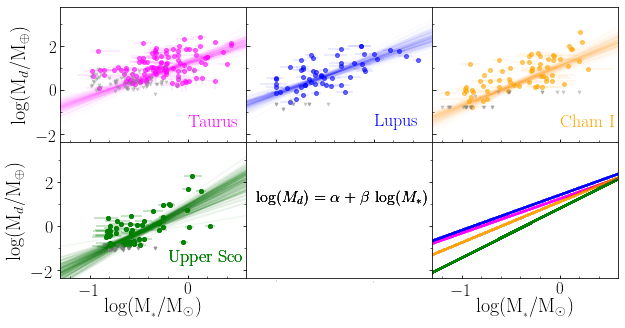

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5) ,sharey=True,sharex=True)
plt.subplots_adjust(wspace=1e-20,hspace=1e-20)
survey=('Taurus','Lupus','Cham I','Upper Sco')
color=('magenta','blue','orange','green')

ax[1,0].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')
ax[0,1].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')
ax[1,2].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')
#ax[0,3].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='16')
ax[0,0].set_ylabel('log(M$_d$/M$_\oplus$)', fontsize='20')
ax[1,0].set_ylabel('log(M$_d$/M$_\oplus$)', fontsize='20')

for j in range(3):
    ax[0,j].text(0, -1.7, survey[j], color=color[j], fontsize=18)
    #ax[0,j].text(-1.2, 3.4, r'$<\alpha>$='"{0:0.2f}".format(a_mean[j]),color=color[j], fontsize=14)   
    #ax[0,j].text(-1.2, 2.9 , r'$<\beta>$='"{0:0.2f}".format(b_mean[j]),color=color[j], fontsize=14)   
    #ax[0,j].text(-1.2, 2.4, r'$<\sigma>$='"{0:0.2f}".format(sig_mean[j]),color=color[j], fontsize=14)   
    ax[0,j].set_ylim(-2.4,3.8)  
    ax[0,j].set_xlim(-1.3,0.6)
    ax[0,j].errorbar(logMs[j][delta[j]],logMd[j][delta[j]],xerr=[Dn_x[j][delta[j]],Dp_x[j][delta[j]]],
                     yerr=[Dn_y[j][delta[j]],Dp_y[j][delta[j]]],
                     fmt='o', color=color[j], markersize=4, alpha=0.1)
    ax[0,j].errorbar(logMs[j][delta[j]],logMd[j][delta[j]],fmt='o', color=color[j], markersize=4, alpha=0.5)
    ax[0,j].errorbar(logMs[j][notdelta[j]],logMd[j][notdelta[j]],fmt='v',color='grey', markersize=3, alpha=0.3)
    ax[0,j].tick_params(axis='both',which='both', labelsize=17,direction='in')
    ax[1,j].tick_params(axis='x',which='both', labelsize=17,direction='in')
    #ax.tick_params(direction='out', length=6, width=2, colors='r')
    ax[0,j].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,j].yaxis.set_minor_locator(AutoMinorLocator(2))

    ax[1,0].text(-0.2, -1.7, survey[3],color=color[3], fontsize=18)
    #ax[1,0].text(-1.2, 3.4, r'$<\alpha>$='"{0:0.2f}".format(a_mean[3]),color=color[3], fontsize=14)   
    #ax[1,0].text(-1.2, 2.9 , r'$<\beta>$='"{0:0.2f}".format(b_mean[3]),color=color[3], fontsize=14)   
    #ax[1,0].text(-1.2, 2.4, r'$<\sigma>$='"{0:0.2f}".format(sig_mean[3]),color=color[3], fontsize=14)   
    ax[1,0].set_ylim(-2.4,3.8)  
    ax[1,0].set_xlim(-1.3,0.6)
    ax[1,0].errorbar(logMs[3][delta[3]],logMd[3][delta[3]], fmt='o', color=color[3], markersize=4,alpha=0.5)
    ax[1,0].errorbar(logMs[3][delta[3]],logMd[3][delta[3]], xerr=[Dn_x[3][delta[3]],Dp_x[3][delta[3]]],
                     yerr=[Dn_y[3][delta[3]],Dp_y[3][delta[3]]],
                     fmt='o', color=color[3], markersize=4,alpha=0.1)
    ax[1,0].errorbar(logMs[3][notdelta[3]],logMd[3][notdelta[3]],fmt='v',color='grey', markersize=3, alpha=0.3)
    ax[1,0].tick_params(axis='y', labelsize=18)

    ax[1,1].text(-1.2, 1, r'log$(M_d)=\alpha+\beta$ log$(M_*)$', fontsize=16) 
    ax[1,1].tick_params(axis='x', which='both', labelsize=1, bottom='off')
    
    for i in xrange(0, len(a_tot[j]), 2000):
        xs = np.arange(-10,10)
        ys1 = a_tot[j][i] + xs * b_tot[j][i]
        ax[0,j].plot(xs,ys1, color=color[j], alpha=0.02)
        ys3= a_tot[3][i] + xs * b_tot[3][i]
        ax[1,0].plot(xs,ys3, color=color[3], alpha=0.02)

        ax[1,2].plot(xs,a_mean[j]+xs*b_mean[j], color=color[j], alpha=0.02, linewidth=2.5)
        ax[1,2].plot(xs,a_mean[3]+xs*b_mean[3], color=color[3], alpha=0.02, linewidth=2.5)
        
    
plt.show()

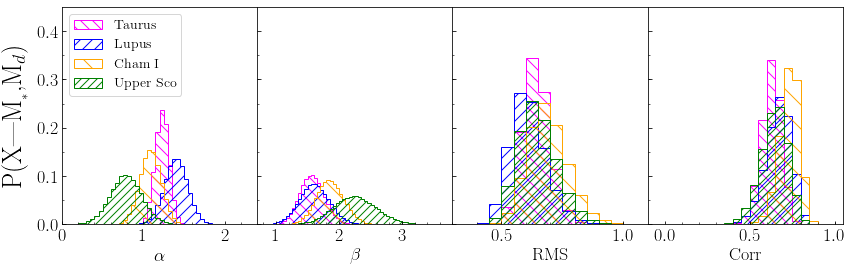

In [5]:
### histograms for Bayesian outcomes
w1 = np.ones_like(a_tot[0])/float(len(a_tot[0]))

fig1, ax1 = plt.subplots(1, 4, figsize=(14, 4) ,sharey=True)
plt.subplots_adjust(wspace=0,hspace=0.01)
label=(r'$\alpha$',r'$\beta$','RMS','Corr')
hatch=("\\\ ","//","\\ ",'///')
survey=('Taurus','Lupus','Cham I','Upper Sco')
color=('magenta','blue','orange','green')
    
ax1[0].set_ylabel('P(X|M$_{_*}$,M$_d$)', fontsize=26)
ax1[0].set_xlim(0,2.4)
ax1[1].set_xlim(0.7,3.8)
ax1[2].set_xlim(0.3,1.1)
ax1[3].set_xlim(-0.1,1.05)

bin1=np.arange(0.2,2.4,0.05)
bin2=np.arange(0.5,3.8,0.05)       
bin3=np.arange(0.3,1.1,0.05)
bin4=np.arange(-0.1,1.05,0.05)

for j in range(4):
    ax1[j].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1[j].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax1[j].tick_params(axis='x', which='both', labelsize=18, direction='in')
    ax1[j].tick_params(axis='y', which='both', labelsize=18, direction='in')
    ax1[j].set_ylim(0,0.45)
    ax1[j].set_xlabel(label[j],fontsize=18)

    ax1[0].hist(a_tot[j],bins=bin1 ,weights=w1, edgecolor=color[j], hatch=hatch[j],histtype='step',label=survey[j])
    ax1[1].hist(b_tot[j],bins=bin2 ,weights=w1, edgecolor=color[j], hatch=hatch[j],histtype='step',label=survey[j])
    ax1[2].hist(s_tot[j],bins=bin3 ,weights=w1, edgecolor=color[j], hatch=hatch[j],histtype='step',label=survey[j])
    ax1[3].hist(corr_tot[j],bins=bin4,weights=w1,edgecolor=color[j], hatch=hatch[j],histtype='step',label=survey[j])
    ax1[0].legend(loc='upper left',prop={'size':14})
plt.show()


### plot Mgas vs Mstar


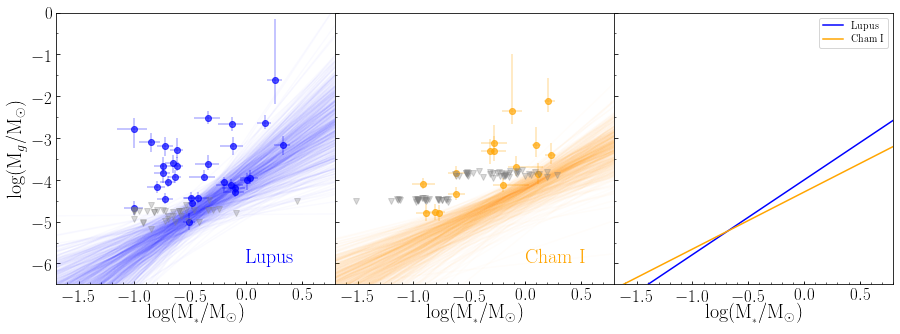

In [6]:
fig, ax_g = plt.subplots(1,3, figsize=(15, 5) ,sharey=True,sharex=True)
plt.subplots_adjust(wspace=1e-20)
survey=('Taurus','Lupus','Cham I','Upper Sco')
color=('magenta','blue','orange','green')

ax_g[0].set_ylabel('log(M$_g$/M$_\odot$)', fontsize='20')
ax_g[0].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')
ax_g[1].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')
ax_g[2].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')

for j in range(2):
    ax_g[j].text(0, -6, survey[j+1],color=color[j+1], fontsize=20)
    #ax_g[j].text(-1.5, -0.4, r'$<\alpha>$ = '"{0:0.2f}".format(a_gasmean[j]),color=color[j+1], fontsize=14)   
    #ax_g[j].text(-1.5, -0.8 , r'$<\beta>$ = '"{0:0.2f}".format(b_gasmean[j]),color=color[j+1], fontsize=14)   
    #ax_g[j].text(-1.5, -1.2, r'$<\sigma>$ = '"{0:0.2f}".format(sig_gasmean[j]),color=color[j+1], fontsize=14)   
    ax_g[j].set_ylim(-6.5,0)  
    ax_g[j].set_xlim(-1.7,0.8)
    ax_g[j].errorbar(logMs[j+1][dGas[j]],logMg[j][dGas[j]],
                     fmt='o', color=color[j+1], alpha=0.5)
    ax_g[j].errorbar(logMs[j+1][dGas[j]],logMg[j][dGas[j]],xerr=[Dn_x[j+1][dGas[j]],Dp_x[j+1][dGas[j]]],
                     yerr=[Dn_ygas[j][dGas[j]],Dp_ygas[j][dGas[j]]],
                     fmt='o', color=color[j+1], alpha=0.3)
    ax_g[j].errorbar(logMs[j+1][notdGas[j]],logMg[j][notdGas[j]],fmt='v',color='grey', alpha=0.3)
    ax_g[j].tick_params(axis='both', labelsize=18)
    ax_g[j].tick_params(axis='both',which='both', labelsize=17,direction='in')
    ax_g[2].tick_params(axis='both', labelsize=18)
    ax_g[2].tick_params(axis='both',which='both', labelsize=17,direction='in')
    ax_g[j].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_g[j].yaxis.set_minor_locator(AutoMinorLocator(2))
    
    for i in xrange(0, len(a_gastot[j]), 500):
        xs_gas = np.arange(-10,10)
        ys1_gas = a_gastot[j][i] + xs_gas * b_gastot[j][i]
        ax_g[j].plot(xs_gas,ys1_gas, color=color[j+1], alpha=0.02)

        #ax_g[2].plot(xs_gas,a_gasmean[j]+xs_gas*b_gasmean[j], color=color[j+1], alpha=0.02)
    ax_g[2].plot(xs_gas,a_gasmean[j]+xs_gas*b_gasmean[j], color=color[j+1], label=survey[j+1])
    
plt.legend()
plt.show()

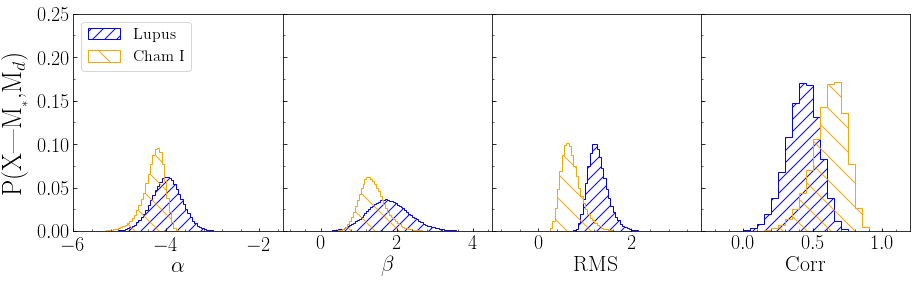

In [7]:
#histogram for the Bayesian outcomes.  (gas)
w1_gL = np.ones_like(a_gastot[0])/float(len(a_gastot[0]))
w1_gC = np.ones_like(a_gastot[1])/float(len(a_gastot[1]))

w1_g=(w1_gL,w1_gC)
fig1_g, ax1_g = plt.subplots(1, 4, figsize=(15, 4) ,sharey=True)
plt.subplots_adjust(wspace=0,hspace=0.01)
label=(r'$\alpha$',r'$\beta$','RMS','Corr')
hatch=("\\\ ","//","\\ ",'///')
survey=('Taurus','Lupus','Cham I','Upper Sco')
color=('magenta','blue','orange','green')
    
ax1_g[0].set_ylabel('P(X|M$_{_*}$,M$_d$)', fontsize=26)
ax1_g[0].set_xlim(-6,-1.5)
ax1_g[1].set_xlim(-1,4.5)
ax1_g[2].set_xlim(-1,3.5)
ax1_g[3].set_xlim(-0.3,1.2)

bin1_g=np.arange(-6,-1.5,0.05)
bin2_g=np.arange(-1,4.5,0.05)       
bin3_g=np.arange(-1,3,0.05)
bin4_g=np.arange(-0.3,1.2,0.05)

for j in range(4):
    ax1_g[j].tick_params(axis='both', which='both', labelsize=20, direction='in')
    ax1_g[j].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1_g[j].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax1_g[j].set_ylim(0,0.25)
    ax1_g[j].set_xlabel(label[j],fontsize=22)
for j in range(2):
    ax1_g[0].hist(a_gastot[j],bins=bin1_g ,weights=w1_g[j], edgecolor=color[j+1], hatch=hatch[j+1],
                  histtype='step',label=survey[j+1])
    ax1_g[1].hist(b_gastot[j],bins=bin2_g ,weights=w1_g[j], edgecolor=color[j+1], hatch=hatch[j+1],
                  histtype='step',label=survey[j+1])
    ax1_g[2].hist(s_gastot[j],bins=bin3_g ,weights=w1_g[j], edgecolor=color[j+1], hatch=hatch[j+1],
                  histtype='step',label=survey[j+1])
    ax1_g[3].hist(corr_gastot[j],bins=bin4_g ,weights=w1_g[j], edgecolor=color[j+1], hatch=hatch[j+1],
                  histtype='step',label=survey[j+1])
    
ax1_g[0].legend(loc='upper left',prop={'size':16})
plt.show()


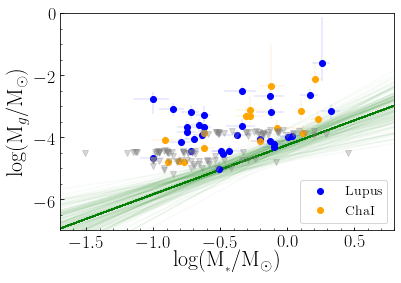

In [8]:
### plot for the LupChaI merged sample. 
x_LupCha= np.concatenate((np.array(logMs_Lup), np.array(logMs_ChaI) )) # logMstar in solar masses
y_LupCha= np.concatenate((np.array(logMg_Lup), np.array(logMg_ChaI) )) # logMgas in solar masses

Dnx_LupCha= np.concatenate(( np.array(Dn_xLup), np.array(Dn_xChaI) )) # inferior error bar on logMstar
Dpx_LupCha= np.concatenate(( np.array(Dp_xLup), np.array(Dp_xChaI) )) # superior errorbar on logMstar 
Dny_LupCha= np.concatenate(( np.array(Dn_ygas_Lup), np.array(Dn_ygas_ChaI) )) # inferior error bar on logMgas
Dpy_LupCha= np.concatenate(( np.array(Dp_ygas_Lup), np.array(Dp_ygas_ChaI) )) # superior error bar logMgas   

dGas_LupCha=np.concatenate(( np.array(dGas_Lup), np.array(dGas_ChaI) ))
notdGas_LupCha=np.logical_not(dGas_LupCha)

LupCha_gas=ascii.read('LupCha_Mg_vs_Ms.pyout')

a_LupCha=LupCha_gas['alpha']
b_LupCha=LupCha_gas['beta']
sig_LupCha=np.sqrt(LupCha_gas['sigsqr'])
corr_LupCha=LupCha_gas['corr']

a_LupChamean=a_LupCha.mean()
a_LupChastd=a_LupCha.std()
b_LupChamean=b_LupCha.mean()
b_LupChastd=b_LupCha.std()
sig_LupChamean=sig_LupCha.mean()
sig_LupChastd=sig_LupCha.std()
corr_LupChamean=corr_LupCha.mean()
corr_LupChastd=corr_LupCha.std()

plt.ylabel('log(M$_g$/M$_\odot$)', fontsize='22')
plt.xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='22')
plt.ylim(-7,0)  
plt.xlim(-1.7,0.8)
plt.errorbar(logMs_Lup[dGas_Lup],logMg_Lup[dGas_Lup], fmt='o', color='blue', label='Lupus')    
plt.errorbar(logMs_ChaI[dGas_ChaI],logMg_ChaI[dGas_ChaI], fmt='o', color='orange', label='ChaI')  
plt.errorbar(logMs_Lup[dGas_Lup],logMg_Lup[dGas_Lup],xerr=[Dn_xLup[dGas_Lup],Dp_xLup[dGas_Lup]],
             yerr=[Dn_ygas_Lup[dGas_Lup],Dp_ygas_Lup[dGas_Lup]], fmt='o', 
             color='blue', alpha=0.1,label='_nolegend_')    
plt.errorbar(logMs_ChaI[dGas_ChaI],logMg_ChaI[dGas_ChaI],xerr=[Dn_xChaI[dGas_ChaI],Dp_xChaI[dGas_ChaI]],
             yerr=[Dn_ygas_ChaI[dGas_ChaI],Dp_ygas_ChaI[dGas_ChaI]], fmt='o', 
             color='orange', alpha=0.1,label='_nolegend_')  
plt.errorbar(logMs_Lup[notdGas[0]],logMg_Lup[notdGas[0]], xerr=0, yerr=0, fmt='v', 
             color='grey',alpha=0.3, label='_nolegend_')
plt.errorbar(logMs_ChaI[notdGas[1]],logMg_ChaI[notdGas[1]], xerr=0, yerr=0, fmt='v', 
             color='grey',alpha=0.3,label='_nolegend_')
    
for i in xrange(0, len(a_LupCha), 500):
    xs_LupCha = np.arange(-10,10)
    ys_LupCha = a_LupCha[i] + xs_LupCha * b_LupCha[i]
    plt.plot(xs_LupCha,ys_LupCha, color='green', alpha=0.03)

    plt.plot(xs_LupCha,a_LupChamean+xs_LupCha*b_LupChamean, color='green', alpha=0.04)

plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.legend(loc='lower right',prop={'size':14})
plt.minorticks_on()
plt.show()

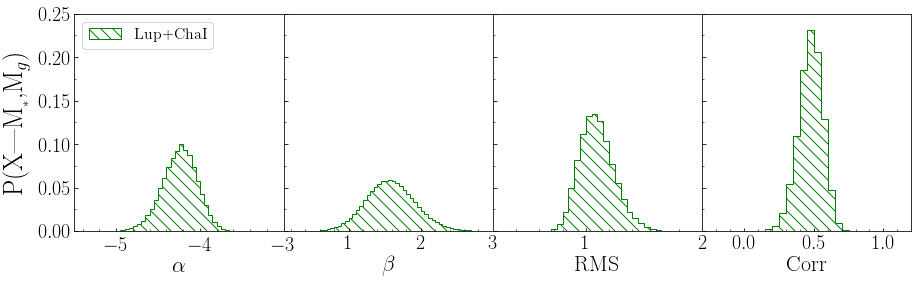

In [9]:
#histogram for the Bayesian outcomes for LupChaI merged sample (gas)
w1_lc = np.ones_like(a_LupCha)/float(len(a_LupCha))

fig1_lc, ax1_lc = plt.subplots(1, 4, figsize=(15, 4) ,sharey=True)
plt.subplots_adjust(wspace=0,hspace=0.01)
label=(r'$\alpha$',r'$\beta$','RMS','Corr')
hatch=("\\\ ","//","\\ ",'///')
survey=('Taurus','Lupus','Cham I','Upper Sco')
color=('magenta','blue','orange','green')
    
ax1_lc[0].set_ylabel('P(X|M$_{_*}$,M$_g$)', fontsize=26)
ax1_lc[0].set_xlim(-5.5,-3)
ax1_lc[1].set_xlim(0.1,3)
ax1_lc[2].set_xlim(0.2,2)
ax1_lc[3].set_xlim(-0.3,1.2)

bin1_lc=np.arange(-5.5,-3,0.05)
bin2_lc=np.arange(0.1,3,0.05)       
bin3_lc=np.arange(0.2,2,0.05)
bin4_lc=np.arange(-0.3,1.2,0.05)

for j in range(4):
    ax1_lc[j].set_ylim(0,0.25)
    ax1_lc[j].set_xlabel(label[j],fontsize=22)
    ax1_lc[j].tick_params(axis='both', which='both', labelsize=20, direction='in')
    ax1_lc[j].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1_lc[j].yaxis.set_minor_locator(AutoMinorLocator(2))

    
ax1_lc[0].hist(a_LupCha,bins=bin1_lc ,weights=w1_lc, edgecolor='green', hatch="\\\ " ,
               histtype='step',label='Lup+ChaI')
ax1_lc[1].hist(b_LupCha,bins=bin2_lc ,weights=w1_lc, edgecolor='green', hatch="\\\ " ,
               histtype='step',label='Lup+ChaI')
ax1_lc[2].hist(sig_LupCha,bins=bin3_lc ,weights=w1_lc, edgecolor='green', hatch="\\\ " ,
               histtype='step',label='Lup+ChaI')
ax1_lc[3].hist(corr_LupCha,bins=bin4_lc ,weights=w1_lc, edgecolor='green', hatch="\\\ ",
               histtype='step',label='Lup+ChaI')

ax1_lc[0].legend(loc='upper left',prop={'size':16})
plt.show()

#### Plots Gas to dust ratio vs Ms

In [13]:
delta_dustLup=Lup_Tab['l_Md']!='<'     
dGasLup=Mgas_Lup['l_Mgas']!='<'      #observed sources for Mgas      
delta_dustCha=ChaI_Tab['l_Md']!='<' 
dGasChaI=Mgas_ChaI['l_Mgas']!='<'      #observed sources for Mgas
ratioLup=10**Mgas_Lup['logMgas'][delta_dustLup]/(Lup_Tab['Md'][delta_dustLup]/332946)
ratioChaI=10**Mgas_ChaI['logMgas'][delta_dustCha]/(ChaI_Tab['Md'][delta_dustCha]/332946)


delta_LupCha=np.concatenate((dGasLup[delta_dustLup],dGasChaI[delta_dustCha]))        
ratioLupCha=np.concatenate((ratioLup,ratioChaI))
logMs_LupCha=np.concatenate((Column(np.log10(Lup_Tab['M*'][delta_dustLup])), 
                               Column(ChaI_Tab['logM*'][delta_dustCha]) ))

# errors for ChaI  
Dp_yMdCha=np.log10(ChaI_Tab['Md']+ChaI_Tab['e_Md'])-np.log10(ChaI_Tab['Md'])
Dn_yMdCha=np.log10(ChaI_Tab['Md'])-np.log10(ChaI_Tab['Md']-ChaI_Tab['e_Md'])     
Dny_ratioCha=(Mgas_ChaI['Dn_Mg'][delta_dustCha]/np.abs(Mgas_ChaI['logMgas'][delta_dustCha])+
              Dn_yMdCha[delta_dustCha]/np.abs(np.log10(ChaI_Tab['Md'])[delta_dustCha]))*np.abs(np.log10(ratioChaI))
Dpy_ratioCha=(Mgas_ChaI['Dp_Mg'][delta_dustCha]/np.abs(Mgas_ChaI['logMgas'][delta_dustCha])+
              Dp_yMdCha[delta_dustCha]/np.abs(np.log10(ChaI_Tab['Md'][delta_dustCha])))*np.abs(np.log10(ratioChaI))
Dp_xMsCha=ChaI_Tab['up_logM*']-ChaI_Tab['logM*']
Dn_xMsCha=ChaI_Tab['logM*']-ChaI_Tab['down_logM*']
  # errors for Lup
ecal_MdLup=np.sqrt((Lup_Tab['err_Md'])**2+(0.1*Lup_Tab['Md'])**2) 
MdLup=Lup_Tab['Md']
MdLup[np.logical_not(delta_dustLup)]=3*Lup_Tab['err_Md'][np.logical_not(delta_dustLup)]
Dp_yMdLup=np.log10(MdLup+ecal_MdLup)-np.log10(MdLup)
Dn_yMdLup=np.log10(MdLup)-np.log10(MdLup-ecal_MdLup)
Dny_ratioLup=(Mgas_Lup['Dn_Mg'][delta_dustLup]/np.abs(Mgas_Lup['logMgas'][delta_dustLup])+
              Dn_yMdLup[delta_dustLup]/np.abs(np.log10(MdLup)[delta_dustLup]))*np.abs(np.log10(ratioLup))
Dpy_ratioLup=(Mgas_Lup['Dp_Mg'][delta_dustLup]/np.abs(Mgas_Lup['logMgas'][delta_dustLup])+
              Dp_yMdLup[delta_dustLup]/np.abs(np.log10(MdLup)[delta_dustLup]))*np.abs(np.log10(ratioLup))
Dp_xMsLup=np.log10(Lup_Tab['M*']+Lup_Tab['err_M*'])-np.log10(Lup_Tab['M*'])  
Dn_xMsLup=np.log10(Lup_Tab['M*'])-np.log10(Lup_Tab['M*']-Lup_Tab['err_M*']) 
            
#combine Lup and Cha data
Dn_yratioLupCha=np.concatenate((Column(Dny_ratioLup),Column(Dny_ratioCha)))
Dp_yratioLupCha=np.concatenate((Column(Dpy_ratioLup),Column(Dpy_ratioCha)))
Dn_xMsLupCha=np.concatenate((Column(Dn_xMsLup[delta_dustLup]), Column(Dn_xMsCha[delta_dustCha])))
Dp_xMsLupCha=np.concatenate((Column(Dp_xMsLup[delta_dustLup]), Column(Dp_xMsCha[delta_dustCha])))


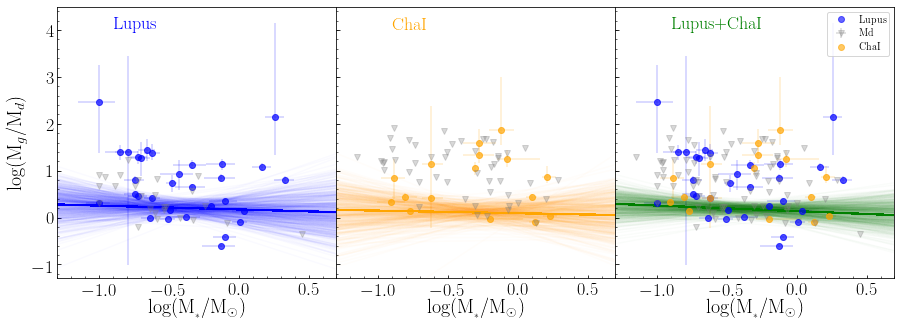

In [21]:
# Plot all together ratio vs Ms (Lup, ChaI, Lup+ChaI)
fig, ax = plt.subplots(1, 3, figsize=(15, 5) ,sharey=True)
plt.subplots_adjust(wspace=1e-20,hspace=1e-20)
survey=('Lupus','ChaI','Lupus+ChaI')
color=('blue','orange','green')

delta_ratio=(dGasLup[delta_dustLup], dGasChaI[delta_dustCha],delta_LupCha)
notdelta_ratio=(np.logical_not(dGasLup[delta_dustLup]), np.logical_not(dGasChaI[delta_dustCha]),
                np.logical_not(delta_LupCha))
ratio=(ratioLup,ratioChaI,ratioLupCha)
logMs_det=(np.log10(Lup_Tab['M*'][delta_dustLup]), ChaI_Tab['logM*'][delta_dustCha], logMs_LupCha)

Dnx_det=(Dn_xMsLup[delta_dustLup],Dn_xMsCha[delta_dustCha], Dn_xMsLupCha)
Dpx_det=(Dp_xMsLup[delta_dustLup],Dp_xMsCha[delta_dustCha],Dp_xMsLupCha)
Dny_ratio=(Dny_ratioLup, Dny_ratioCha, Dn_yratioLupCha)
Dpy_ratio=(Dpy_ratioLup, Dpy_ratioCha, Dp_yratioLupCha)

ratioLup_out=ascii.read('ratioLup_vs_Ms.pyout')
ratioCha_out=ascii.read('ratioCha_vs_Ms.pyout')
ratioLupCha_out=ascii.read('ratioLupCha_vs_Ms.pyout')

a_ratioLup=ratioLup_out['alpha']
b_ratioLup=ratioLup_out['beta']
sig_ratioLup=np.sqrt(ratioLup_out['sigsqr'])
corr_ratioLup=ratioLup_out['corr']

a_ratioCha=ratioCha_out['alpha']
b_ratioCha=ratioCha_out['beta']
sig_ratioCha=np.sqrt(ratioCha_out['sigsqr'])
corr_ratioCha=ratioCha_out['corr']

a_ratioLupCha=ratioLupCha_out['alpha']
b_ratioLupCha=ratioLupCha_out['beta']
sig_ratioLupCha=np.sqrt(ratioLupCha_out['sigsqr'])
corr_ratioLupCha=ratioLupCha_out['corr']

a_ratiotot=(a_ratioLup, a_ratioCha, a_ratioLupCha)
b_ratiotot=(b_ratioLup, b_ratioCha, b_ratioLupCha)
sig_ratiotot=(sig_ratioLup, sig_ratioCha, sig_ratioLupCha)
corr_ratiotot=(corr_ratioLup, corr_ratioCha, corr_ratioLupCha)

ax[0].set_ylabel('log(M$_g$/M$_d$)', fontsize='20')

for j in range(2):
    ax[j].errorbar(logMs_det[j][delta_ratio[j]],np.log10(ratio[j][delta_ratio[j]]),
             xerr=[Dnx_det[j][delta_ratio[j]],Dpx_det[j][delta_ratio[j]]],
             yerr=[Dny_ratio[j][delta_ratio[j]],Dpy_ratio[j][delta_ratio[j]]], 
             fmt='o', color=color[j], label='_nolegend_', alpha=0.2)
    ax[j].errorbar(logMs_det[j][delta_ratio[j]],np.log10(ratio[j][delta_ratio[j]]),
             fmt='o', color=color[j], label=survey[j], alpha=0.6)
    ax[j].errorbar(logMs_det[j][notdelta_ratio[j]],np.log10(ratio[j][notdelta_ratio[j]]),
             xerr=0, yerr=0, fmt='v', color='grey',alpha=0.3)
    ax[j].tick_params(axis='both',which='both', labelsize=18,direction='in')
    
    ax[2].errorbar(logMs_det[j][delta_ratio[j]],np.log10(ratio[j][delta_ratio[j]]),
             xerr=[Dnx_det[j][delta_ratio[j]],Dpx_det[j][delta_ratio[j]]],
             yerr=[Dny_ratio[j][delta_ratio[j]],Dpy_ratio[j][delta_ratio[j]]], 
             fmt='o', color=color[j], label='_nolegend_', alpha=0.2)
    ax[2].errorbar(logMs_det[j][delta_ratio[j]],np.log10(ratio[j][delta_ratio[j]]),
             fmt='o', color=color[j], label=survey[j], alpha=0.6)
    ax[2].errorbar(logMs_det[j][notdelta_ratio[j]],np.log10(ratio[j][notdelta_ratio[j]]),
             xerr=0, yerr=0, fmt='v', color='grey',alpha=0.3)
    ax[2].tick_params(axis='both',which='both', labelsize=18,direction='in')

for j in range(3):
    ax[j].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize='20')
    ax[j].text(-0.9, 4, survey[j], color=color[j], fontsize=18)
    ax[j].set_ylim(-1.3,4.5)  
    ax[j].set_xlim(-1.3,0.7)
    ax[j].minorticks_on() 
    for i in xrange(0, len(a_ratiotot[j]), 500):
        xs = np.arange(-10,10)
        ys1 = a_ratiotot[j][i] + xs * b_ratiotot[j][i]
        ax[j].plot(xs,ys1, color=color[j], alpha=0.02)
        ax[j].plot(xs,a_ratiotot[j].mean()+xs*b_ratiotot[j].mean(), color=color[j], alpha=0.02)

plt.legend()
plt.show()

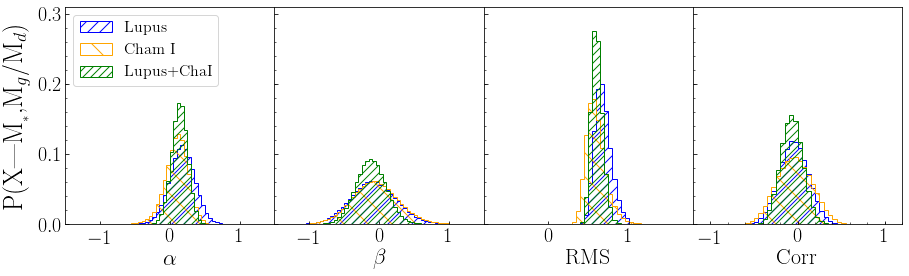

In [23]:
#histogram for the Bayesian outcomes for rartio vs Ms (Lup, ChaI, Lup+ChaI)
w_ratio = np.ones_like(a_ratiotot[0])/float(len(a_ratiotot[0]))

fig1_ratio, ax1_ratio = plt.subplots(1, 4, figsize=(15, 4) ,sharey=True)
plt.subplots_adjust(wspace=0,hspace=0.01)
label=(r'$\alpha$',r'$\beta$','RMS','Corr')
hatch=("\\\ ","//","\\ ",'///')
survey=('none','Lupus','Cham I','Lupus+ChaI')
color=('red','blue','orange','green')
    
ax1_ratio[0].set_ylabel('P(X|M$_{_*}$,M$_g$/M$_d$)', fontsize=26)
ax1_ratio[0].set_xlim(-1.5,1.5)
ax1_ratio[1].set_xlim(-1.5,1.5)
ax1_ratio[2].set_xlim(-0.8,1.8)
ax1_ratio[3].set_xlim(-1.2,1.2)

bin1_ratio=np.arange(-1.5,1.5,0.05)
bin2_ratio=np.arange(-1.5,1.5,0.05)       
bin3_ratio=np.arange(-0.8,1.8,0.05)
bin4_ratio=np.arange(-1.2,1.2,0.05)

for j in range(4):
    ax1_ratio[j].tick_params(axis='both', which='both', labelsize=20, direction='in')
    ax1_ratio[j].set_ylim(0,0.31)
    ax1_ratio[j].set_xlabel(label[j],fontsize=22)
for j in range(3):
    ax1_ratio[0].hist(a_ratiotot[j],bins=bin1_ratio ,weights=w_ratio, edgecolor=color[j+1], 
                      hatch=hatch[j+1] ,histtype='step',label=survey[j+1])
    ax1_ratio[1].hist(b_ratiotot[j],bins=bin2_ratio ,weights=w_ratio, edgecolor=color[j+1], 
                      hatch=hatch[j+1] ,histtype='step',label=survey[j+1])
    ax1_ratio[2].hist(sig_ratiotot[j],bins=bin3_ratio ,weights=w_ratio, edgecolor=color[j+1], 
                      hatch=hatch[j+1] ,histtype='step',label=survey[j+1])
    ax1_ratio[3].hist(corr_ratiotot[j],bins=bin4_ratio ,weights=w_ratio, edgecolor=color[j+1], 
                      hatch=hatch[j+1],histtype='step',label=survey[j+1])

ax1_ratio[0].legend(loc='upper left',prop={'size':16})
plt.minorticks_on()
plt.show()